**Author**: Sangyoon Park

**Date**: 2020-12-18

**Objective**: This notebooks aims to examine LUNA's behavior on different gap location. 

Specifically, it uses the that and examines 
First, it grid-searches the ideal parameter values for the gap at center (i.e. `diversification strength (DIV)` $\times$ `regularization strength (REG)` while fixing `number of auxiliary functions (AUX)`), and then it examines whether these parameter values work for other gap locations (left and right).

In [ ]:
# Configure environment
from os import path
CURR_PATH = path.abspath("__file__") # Full path to current script
ROOT_PATH = path.dirname(path.dirname(CURR_PATH))
import sys; sys.path.insert(0, ROOT_PATH)

In [ ]:
import time
from src.models import LUNA
from src.utils import generate_data, format_time, neg_log_likelihood, epistemic_uncertainty

In [ ]:
from autograd import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def experiment_LUNA_1D(x_train, y_train, n_aux=30, reg_param=600, lambda_in=1000, step_size=1e-2, max_iteration=3000):
    activation_fn_type = 'relu'
    activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

    input_dim = 1
    output_dim = 1
    width = [50,50] # using the architecture used in the paper

    architecture = {
        'width': width,
        'input_dim': input_dim,
        'output_dim': output_dim,
        'activation_fn_type': 'relu',
        'activation_fn_params': 'rate=1',
        'activation_fn': activation_fn,
        'auxiliary_functions': n_aux,
    }

    params = {
        'step_size': step_size,
        'max_iteration': max_iteration,
        'random_restarts': 1,
        'reg_param': reg_param,
        'lambda_in': lambda_in,
    }

    rand_state = 207
    random = np.random.RandomState(rand_state)

    luna = LUNA(architecture, random=random)
    print("")
    print(f"===== [ Aux Functions: {n_aux} ] === [ Regularization: {reg_param} ] === [ Diversification: {lambda_in} ] =====")
    print("")
    t0 = time.time()
    luna.fit(x_train, y_train, params)
    print("")
    print("Training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))

    return luna

## Train LUNA on Different Gap Locations

### Gap in the Middle

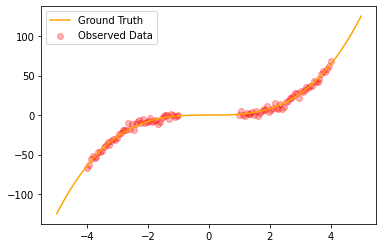

In [ ]:
# Generate toy data
x, y, x_test, y_test = generate_data(data_region=[(-4,-1),(1,4)], number_of_points=[50,50])
plt.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
plt.legend()
plt.show()

# Extract test gap data
gap_idx = np.logical_and(x_test > -1, x_test < 1)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

# Extract test non-gap data
non_gap_idx = np.logical_and(np.logical_and(x_test > -4, x_test < 4), np.logical_not(gap_idx))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

In [ ]:
luna = experiment_LUNA_1D(x, y)


===== [ Aux Functions: 30 ] === [ Regularization: 600 ] === [ Diversification: 1000 ] =====

Iteration 0 loss 11864.29443943256; gradient mag: 5853.749278101462
Iteration 100 loss 1209.2071275938588; gradient mag: 1161.2677897235449
Iteration 200 loss 1122.3738261692797; gradient mag: 607.473944793331
Iteration 300 loss 1019.554173956328; gradient mag: 432.6534320258294
Iteration 400 loss 977.8249562513082; gradient mag: 452.83023649899604
Iteration 500 loss 937.6580708396401; gradient mag: 1187.7569938681993
Iteration 600 loss 908.365230155405; gradient mag: 418.11777852375525
Iteration 700 loss 876.2470547782584; gradient mag: 198.67956243501266
Iteration 800 loss 864.1842609222444; gradient mag: 299.83576345832876
Iteration 900 loss 846.0966504980543; gradient mag: 285.5117306247478
Iteration 1000 loss 828.5388244657079; gradient mag: 396.6074161019299
Iteration 1100 loss 814.8765162483717; gradient mag: 258.85666100597075
Iteration 1200 loss 803.8066993218263; gradient mag: 57.196

In [ ]:
luna.data = (x, y, x_test, y_test)

prior_mean = 0; prior_var = 9; noise_var = 9

y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_train = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_train_noise = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap_noise = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)
y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap_noise = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

luna.ll_train = np.round(neg_log_likelihood(y_posterior_train_noise, y, noise_var), 2)
luna.ll_test = np.round(neg_log_likelihood(y_posterior_non_gap_noise, y_test_non_gap, noise_var), 2)
luna.eu_gap = np.round(epistemic_uncertainty(y_posterior_gap), 2)
luna.eu_nongap = np.round(epistemic_uncertainty(y_posterior_non_gap), 2)

In [ ]:
luna_middle = luna

### Gap on the Right

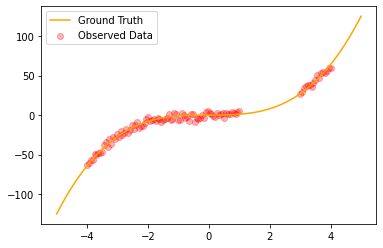

In [ ]:
# Generate toy data
x, y, x_test, y_test = generate_data(data_region=[(-4,1),(3,4)], number_of_points=[83,17])
plt.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
plt.legend()
plt.show()

# Extract test gap data
gap_idx = np.logical_and(x_test > 1, x_test < 3)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

# Extract test non-gap data
non_gap_idx = np.logical_and(np.logical_and(x_test > -4, x_test < 4), np.logical_not(gap_idx))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

In [ ]:
luna = experiment_LUNA_1D(x, y)


===== [ Aux Functions: 30 ] === [ Regularization: 600 ] === [ Diversification: 1000 ] =====

Iteration 0 loss 10990.065023496842; gradient mag: 5460.570419449733
Iteration 100 loss 1188.4644845525972; gradient mag: 630.8647311947392
Iteration 200 loss 1044.2905429335483; gradient mag: 706.1798680166122
Iteration 300 loss 991.4115218607844; gradient mag: 415.3308005206224
Iteration 400 loss 932.3875137401169; gradient mag: 354.86495519170666
Iteration 500 loss 885.1883257890106; gradient mag: 279.7859155427546
Iteration 600 loss 880.3510397422314; gradient mag: 655.4046964187785
Iteration 700 loss 822.0881827305332; gradient mag: 335.8974677040939
Iteration 800 loss 801.8385364180762; gradient mag: 275.902807942431
Iteration 900 loss 788.7486667574283; gradient mag: 621.5878838230501
Iteration 1000 loss 765.6659902600132; gradient mag: 460.3339546703716
Iteration 1100 loss 753.5064222346491; gradient mag: 329.7106278443681
Iteration 1200 loss 739.4591518170716; gradient mag: 321.142645

In [ ]:
luna.data = (x, y, x_test, y_test)

prior_mean = 0; prior_var = 9; noise_var = 9

y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_train = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_train_noise = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap_noise = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)
y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap_noise = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

luna.ll_train = np.round(neg_log_likelihood(y_posterior_train_noise, y, noise_var), 2)
luna.ll_test = np.round(neg_log_likelihood(y_posterior_non_gap_noise, y_test_non_gap, noise_var), 2)
luna.eu_gap = np.round(epistemic_uncertainty(y_posterior_gap), 2)
luna.eu_nongap = np.round(epistemic_uncertainty(y_posterior_non_gap), 2)

In [ ]:
luna_right = luna

### Gap on the Left

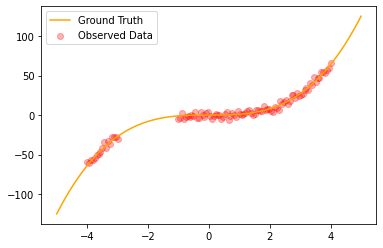

In [ ]:
# Generate toy data
x, y, x_test, y_test = generate_data(data_region=[(-4,-3),(-1,4)], number_of_points=[17,83])
plt.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
plt.legend()
plt.show()

# Extract test gap data
gap_idx = np.logical_and(x_test > -3, x_test < -1)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

# Extract test non-gap data
non_gap_idx = np.logical_and(np.logical_and(x_test > -4, x_test < 4), np.logical_not(gap_idx))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

In [ ]:
luna = experiment_LUNA_1D(x, y)


===== [ Aux Functions: 30 ] === [ Regularization: 600 ] === [ Diversification: 1000 ] =====

Iteration 0 loss 10032.386312391038; gradient mag: 4840.442568884862
Iteration 100 loss 1222.4722094765823; gradient mag: 733.2372043771206
Iteration 200 loss 1070.8352398722345; gradient mag: 458.7205749684779
Iteration 300 loss 1004.0131940026902; gradient mag: 728.7731204372507
Iteration 400 loss 953.0612214504133; gradient mag: 430.64375792036464
Iteration 500 loss 897.3976389156264; gradient mag: 409.9504833952998
Iteration 600 loss 870.3316306372687; gradient mag: 540.1999520490275
Iteration 700 loss 850.9150562528789; gradient mag: 292.3069071212953
Iteration 800 loss 842.0843179825052; gradient mag: 262.5045548507969
Iteration 900 loss 802.3415337955785; gradient mag: 522.2369794284579
Iteration 1000 loss 789.3970470764846; gradient mag: 443.20881614146634
Iteration 1100 loss 765.6917012340421; gradient mag: 180.03263675717517
Iteration 1200 loss 754.2968911166013; gradient mag: 328.97

In [ ]:
luna.data = (x, y, x_test, y_test)

prior_mean = 0; prior_var = 9; noise_var = 9

y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior_train = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_train_noise = y_posterior_train + np.random.normal(0, noise_var**0.5, size=y_posterior_train.shape)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap_noise = y_posterior_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_gap.shape)
y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap_noise = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size=y_posterior_non_gap.shape)

luna.ll_train = np.round(neg_log_likelihood(y_posterior_train_noise, y, noise_var), 2)
luna.ll_test = np.round(neg_log_likelihood(y_posterior_non_gap_noise, y_test_non_gap, noise_var), 2)
luna.eu_gap = np.round(epistemic_uncertainty(y_posterior_gap), 2)
luna.eu_nongap = np.round(epistemic_uncertainty(y_posterior_non_gap), 2)

In [ ]:
luna_left = luna

## Compare Results

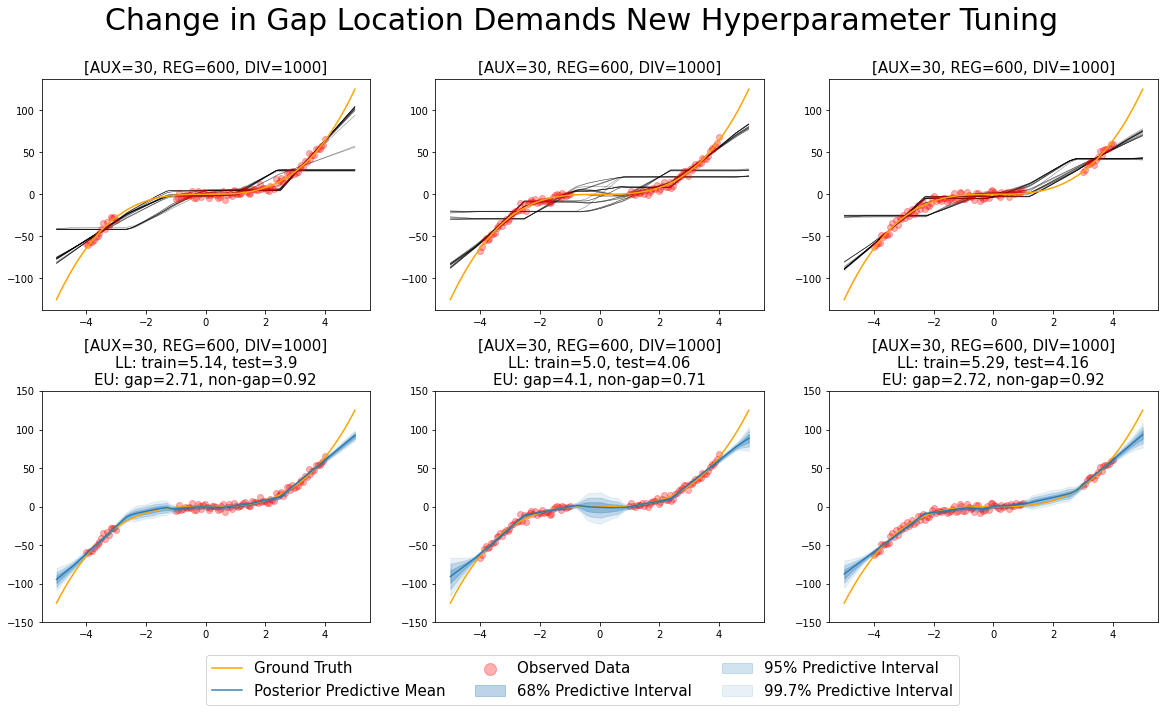

In [ ]:
luna_list = [luna_left, luna_middle, luna_right]

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i, luna in enumerate(luna_list):
    x, y, x_test, y_test = luna.data
    y_pred = luna.forward(luna.weights, x_test)

    ax[0,i].scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax[0,i].plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    ax[0,i].plot(x_test[0,:], np.squeeze(y_pred).T[:,:1], color='black', linewidth=0.5, alpha=0.5, zorder=0, label="Fitted Auxiliary Functions")
    ax[0,i].plot(x_test[0,:], np.squeeze(y_pred).T[:,1:], color='black', linewidth=0.5, alpha=0.5, zorder=0)
    ax[0,i].set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]", fontsize=15)

    y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models=5000)
    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    ax[1,i].scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax[1,i].plot(x_test[0,:], x_test[0,:]**3, color='orange', label="Ground Truth")
    ax[1,i].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax[1,i].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68% Predictive Interval")
    ax[1,i].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95% Predictive Interval")
    ax[1,i].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7% Predictive Interval")
    ax[1,i].set_ylim([-150, 150])
    ax[1,i].set_title(f"[AUX={luna.params['M']}, REG={luna.params['reg_param']}, DIV={luna.params['lambda_in']}]\nLL: train={luna.ll_train}, test={luna.ll_test}\nEU: gap={luna.eu_gap}, non-gap={luna.eu_nongap}", fontsize=15)

handles, labels = ax[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, markerscale=2)
plt.suptitle("Change in Gap Location Demands New Hyperparameter Tuning", fontsize=30)
plt.subplots_adjust(hspace=0.35)
# plt.savefig(path.join(ROOT_PATH, "images", "LUNA_gap_experiment.png"), dpi=150)
plt.show()